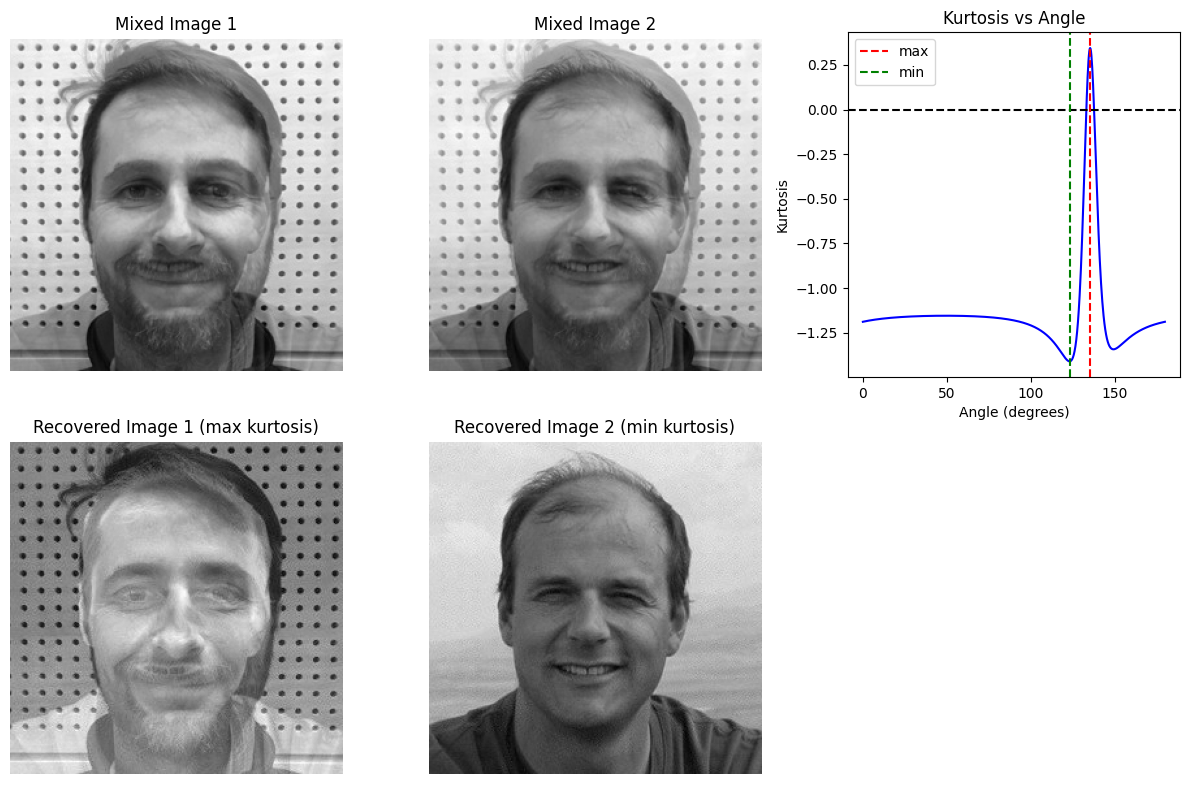

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.stats import kurtosis

# --- Step 1: Load mixed images ---
im1 = './data/mixed1.jpg'
im2 = './data/mixed2.jpg'

X1 = imread(im1).astype(float)
X2 = imread(im2).astype(float)

# Convert to grayscale if RGB
if X1.ndim == 3:
    X1 = X1.mean(axis=2)
if X2.ndim == 3:
    X2 = X2.mean(axis=2)

# Ensure same shape (force Python ints)
h, w = map(int, X1.shape)
X2 = X2[:h, :w]

# --- Step 2: Flatten into signals (pixels as samples) ---
X = np.c_[X1.flatten(), X2.flatten()]  # shape: (n_pixels, 2)

# --- Step 3: Scan kurtosis across projection angles ---
def kurtosis_scan(X, n_angles=720):
    angles = np.linspace(0, np.pi, n_angles)
    kurt_vals = []
    for theta in angles:
        w = np.array([np.cos(theta), np.sin(theta)])
        proj = X @ w
        k = kurtosis(proj, fisher=True)
        kurt_vals.append(k)
    return angles, np.array(kurt_vals)

angles, kurt_vals = kurtosis_scan(X, n_angles=720)

# --- Step 4: Find best extrema ---
best_angle_max = angles[np.argmax(kurt_vals)]  # most super-Gaussian
best_angle_min = angles[np.argmin(kurt_vals)]  # most sub-Gaussian

# --- Step 5: Recover signals ---
def project_signal(X, angle, h, w):
    w_vec = np.array([np.cos(angle), np.sin(angle)])
    proj = X @ w_vec
    proj = (proj - proj.min()) / (proj.max() - proj.min())  # normalize [0,1]
    return proj.reshape(h, w)

rec1 = project_signal(X, best_angle_max, h, w)
rec2 = project_signal(X, best_angle_min, h, w)
rec1 = 1 - rec1
# --- Step 6: Plot results ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0,0].imshow(X1, cmap='gray')
axes[0,0].set_title("Mixed Image 1"); axes[0,0].axis("off")

axes[0,1].imshow(X2, cmap='gray')
axes[0,1].set_title("Mixed Image 2"); axes[0,1].axis("off")

axes[0,2].plot(angles*180/np.pi, kurt_vals, 'b-')
axes[0,2].axhline(0, color='k', linestyle='--')
axes[0,2].axvline(best_angle_max*180/np.pi, color='r', linestyle='--', label="max")
axes[0,2].axvline(best_angle_min*180/np.pi, color='g', linestyle='--', label="min")
axes[0,2].set_title("Kurtosis vs Angle")
axes[0,2].set_xlabel("Angle (degrees)")
axes[0,2].set_ylabel("Kurtosis")
axes[0,2].legend()

axes[1,0].imshow(rec1, cmap='gray')
axes[1,0].set_title("Recovered Image 1 (max kurtosis)"); axes[1,0].axis("off")

axes[1,1].imshow(rec2, cmap='gray')
axes[1,1].set_title("Recovered Image 2 (min kurtosis)"); axes[1,1].axis("off")

axes[1,2].axis("off")  # empty slot

plt.tight_layout()
plt.show()
